In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import phys
import tables
from scipy.optimize import curve_fit

In [203]:
def Gaussian(wv, wv0, sigma, intensity):
    return intensity / (np.sqrt(2. * np.pi) * sigma) *\
           np.exp(-0.5 * ((wv - wv0) / sigma)**2)


def OneGaussianModel(wv, a, b, wv_cen, sigma, intensity):
    return (a * wv + b) * (1 - Gaussian(wv, wv_cen, sigma, intensity))

    
def MultiGaussianModel(wv, a, b, wv_cen_list, sigma_list, intensity_list):
    flux = a * wv + b
    for wv_cen, sigma, intensity in zip(wv_cen_list, sigma_list, intensity_list):
        flux *= (1 - Gaussian(wv, wv_cen, sigma, intensity))
    return flux


def TwoGaussianModel(wv, a, b, wv_cen1, sigma1, intensity1, wv_cen2, sigma2, intensity2):
    return MultiGaussianModel(wv, a, b, [wv_cen1, wv_cen2], [sigma1, sigma2], [intensity1, intensity2])


def FitSpec(spec, model, p0, lambda_range=None):
    if lambda_range is None:
        lambda_range = [spec.data["wavelength"].min(), spec.data["wavelength"].max()]
    idx = np.logical_and(spec.data["wavelength"] >= lambda_range[0],
                         spec.data["wavelength"] <= lambda_range[1])
    wv = spec.data["wavelength"][idx]
    flx = spec.data["flux"][idx]
    popt, pcov = curve_fit(model, wv, flx, p0=p0)
    return popt, pcov

In [204]:
class Spectroscopy(object):
    
    def __init__(self, MJD, telescope, instrument, data, z=0):
        self.MJD = MJD
        self.telescope = telescope
        self.instrument = instrument
        self.data = data
        self.data["wavelength"] /= (1 + z)
        idx = np.logical_and(self.data["wavelength"] > 6000,
                             self.data["wavelength"] < 7000)
        self.data["flux"] /= np.median(self.data["flux"][idx])
        
    def __gt__(self, other):
        return self.MJD > other.MJD
    
    def __lt__(self, other):
        return self.MJD < other.MJD
    
    def __eq__(self, other):
        return self.MJD == other.MJD
    
    def __ge__(self, other):
        return self > other or self == other
    
    def __le__(self, other):
        return self < other or self == other
    
    def plot(self, ax, offset=0, **keywords):
        ax.plot(self.data["wavelength"], 
                self.data["flux"] + offset, 
                **keywords)
    

# load light curve data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table_group = h5file.root.spectroscopy
z = 0.0232
T_MAX = 57499.65

spectra = list()
for table in table_group:
    spec = np.array([(row["wavelength"], row["flux_lambda"])
                     for row in table],
                    dtype=[("wavelength", "f"), ("flux", "f")])
    
    spectra.append(Spectroscopy(table.attrs.OBS_DATE, 
                                table.attrs.TELESCOPE,
                                table.attrs.INSTRUMENT,
                                spec,
                                z=z))
spectra.sort()

Si II 6355: center=6039.9 +/- 2.6, sigma=93.5 +/- 5.1, intensity=21.8 +/- 2.3
C II 6580: center=6262.7 +/- 1.0, sigma=59.0 +/- 1.0, intensity=21.9 +/- 0.5
C II 7234: center=6911.1 +/- 1.6, sigma=53.9 +/- 2.9, intensity=10.8 +/- 0.9
Si II 6355: center=6071.1 +/- 1.1, sigma=82.9 +/- 2.1, intensity=30.3 +/- 1.2
C II 6580: center=6280.0 +/- 1.2, sigma=48.1 +/- 1.1, intensity=12.5 +/- 0.3
C II 7234: center=6931.9 +/- 2.9, sigma=67.1 +/- 4.8, intensity=13.9 +/- 1.7
Si II 6355: center=6097.3 +/- 1.7, sigma=81.6 +/- 3.0, intensity=26.3 +/- 1.3
C II 6580: center=6297.9 +/- 3.6, sigma=45.4 +/- 3.6, intensity=5.7 +/- 0.5
C II 7234: center=6950.7 +/- 1.8, sigma=47.9 +/- 2.3, intensity=6.3 +/- 0.4
Si II 6355: center=6118.4 +/- 1.0, sigma=65.2 +/- 1.3, intensity=24.3 +/- 0.6
C II 6580: center=6321.2 +/- 2.9, sigma=24.1 +/- 3.0, intensity=2.1 +/- 0.3
C II 7234: center=6806.5 +/- 31.3, sigma=304.6 +/- 151.2, intensity=322.3 +/- 363.9


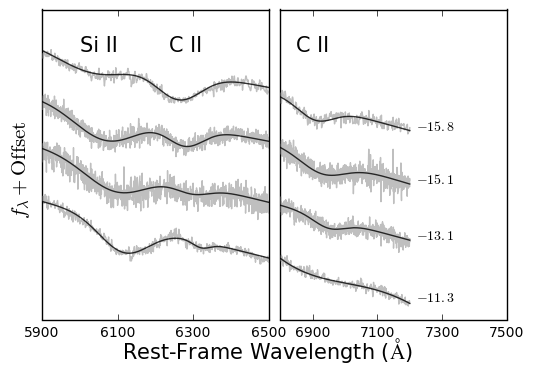

In [205]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.05)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# initial guesses
p0_1 = [[0, 0, 6000, 100, 10, 6250, 50, 20], 
        [0, 0, 6100, 50, 0.1, 6250, 50, 0.2],
        [0, 0, 6100, 50, 0.1, 6280, 50, 0.2],
        [0, 0, 6100, 50, 0.1, 6280, 50, 0.2]]
p0_2 = [[0, 0, 6900, 50, 0.1],
        [0, 0, 6900, 50, 0.1],
        [0, 0, 6900, 50, 0.1],
        [0, 0, 6900, 50, 0.1]]

offset = 0
i = 0
center_wavelengths = list()
pEWs = list()
phases = list()
for spec in spectra[1:5]:
    wv = spec.data["wavelength"]
    flx = spec.data["flux"]
    idx = np.logical_and(wv > 5900, wv < 6550)
    ax1.plot(wv[idx], flx[idx] / np.median(flx[idx]) + offset, color='gray', alpha=0.5, zorder=3)
    popt, pcov = FitSpec(spec, 
                         TwoGaussianModel, 
                         p0_1[i], 
                         lambda_range=[5900, 6550])
    model_flx = TwoGaussianModel(wv[idx], *popt)
    ax1.plot(wv[idx], model_flx / np.median(model_flx) + offset, color='k', alpha=0.8, zorder=5)
    
    # Si II 6355
    center = popt[2]
    center_err = pcov[2][2]**0.5
    width = popt[3]
    width_err = pcov[3][3]**0.5
    intensity = popt[4]
    intensity_err = pcov[4][4]**0.5
    center_measure = [(center, center_err)]
    pEW_measure = [(intensity, intensity_err)]
    print "Si II 6355: center=%.1f +/- %.1f, sigma=%.1f +/- %.1f, intensity=%.1f +/- %.1f" %\
        (center, center_err, width, width_err, intensity, intensity_err)
    
    # C II 6580
    center = popt[5]
    center_err = pcov[5][5]**0.5
    width = popt[6]
    width_err = pcov[6][6]**0.5
    intensity = popt[7]
    intensity_err = pcov[7][7]**0.5
    center_measure.append((center, center_err))
    pEW_measure.append((intensity, intensity_err))
    print "C II 6580: center=%.1f +/- %.1f, sigma=%.1f +/- %.1f, intensity=%.1f +/- %.1f" %\
        (center, center_err, width, width_err, intensity, intensity_err)
        
    idx = np.logical_and(wv > 6800, wv < 7200)
    ax2.plot(wv[idx], flx[idx] / np.median(flx[idx]) + offset - 0.2, color='gray', alpha=0.5, zorder=3)
    popt, pcov = FitSpec(spec, 
                         OneGaussianModel, 
                         p0_2[i], 
                         lambda_range=[6800, 7200])
    model_flx = OneGaussianModel(wv[idx], *popt)
    model_flx /= np.median(model_flx)
    ax2.plot(wv[idx], model_flx + offset - 0.2, color='k', alpha=0.8, zorder=5)
    
    # C II 27234
    center = popt[2]
    center_err = pcov[2][2]**0.5
    width = popt[3]
    width_err = pcov[3][3]**0.5
    intensity = popt[4]
    intensity_err = pcov[4][4]**0.5
    center_measure.append((center, center_err))
    pEW_measure.append((intensity, intensity_err))
    print "C II 7234: center=%.1f +/- %.1f, sigma=%.1f +/- %.1f, intensity=%.1f +/- %.1f" %\
        (center, center_err, width, width_err, intensity, intensity_err)
    
    # phase info
    ax2.text(wv[idx][-1] + 20, np.median(model_flx[-20:-1]) + offset - 0.2,
             "$%+5.1f$" % (spec.MJD - T_MAX))
    
    center_wavelengths.append(center_measure)
    pEWs.append(pEW_measure)
    phases.append(spec.MJD - T_MAX)
    i += 1
    offset -= 0.3

ax1.set_xlim(5900, 6500)
ax2.set_xlim(6800, 7200)
ax1.set_ylim(-0.3, 1.4)
ax2.set_ylim(ax1.get_ylim())
ax1.set_xticks(range(5900, 6600, 200))
ax2.set_xticks(range(6900, 7600, 200))
ax1.set_yticks([])
ax2.set_yticks([])

ax1.text(6050, 1.2, "Si II",
         fontsize=15,
         horizontalalignment="center",
         verticalalignment="center")
ax1.text(6280, 1.2, "C II",
         fontsize=15,
         horizontalalignment="center",
         verticalalignment="center")
ax2.text(6900, 1.2, "C II",
         fontsize=15,
         horizontalalignment="center",
         verticalalignment="center")

fig.text(0.5, 0.05, "Rest-Frame Wavelength ($\\rm{\\AA}$)", 
         fontsize=15,
         horizontalalignment="center",
         verticalalignment="center")
fig.text(0.09, 0.5, "$f_\\lambda + \\rm{Offset}$", 
         fontsize=15,
         horizontalalignment="center",
         verticalalignment="center",
         rotation="vertical")
plt.savefig("CarbonFeature.pdf")

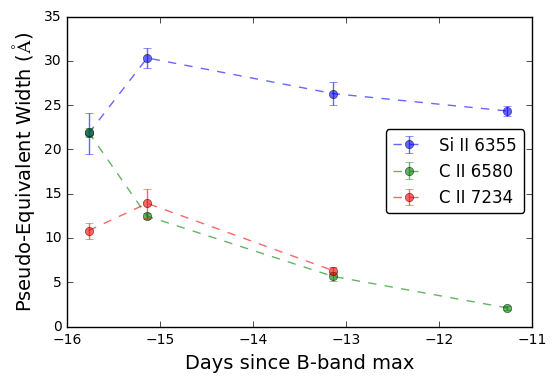

In [206]:
# pEW plot
phases = np.array(phases)
labels = ["Si II 6355", "C II 6580", "C II 7234"]
for i in range(3):
    obs_pEW = np.array([item[i][0] for item in pEWs])
    obs_pEW_err = np.array([item[i][1] for item in pEWs])
    idx = obs_pEW > 3. * obs_pEW_err
    plt.errorbar(phases[idx], obs_pEW[idx], 
                 yerr=obs_pEW_err[idx],
                 label=labels[i],
                 linestyle='--',
                 marker='o',
                 alpha=0.6)
plt.legend(loc="right", numpoints=1, fancybox=True)
plt.xlabel("Days since B-band max", fontsize=14)
plt.ylabel("Pseudo-Equivalent Width ($\\rm{\\AA}$)", fontsize=14)
plt.savefig("pEW.pdf")

In [207]:
# Velocity plot
rest_wave = [6355, 6580, 7234]
vel = dict()
vel_err = dict()
for i in range(3):
    vel[labels[i]] = list()
    vel_err[labels[i]] = list()
    for measurements in center_wavelengths:
        wave, wave_err = measurements[i]
        velocity = (1 - wave / rest_wave[i]) * phys.c / 1e8  # kkm/s
        velocity_err = wave_err / rest_wave[i] * phys.c / 1e8
        vel[labels[i]].append(velocity)
        vel_err[labels[i]].append(velocity_err)
    vel[labels[i]] = np.array(vel[labels[i]])
    vel_err[labels[i]] = np.array(vel_err[labels[i]])

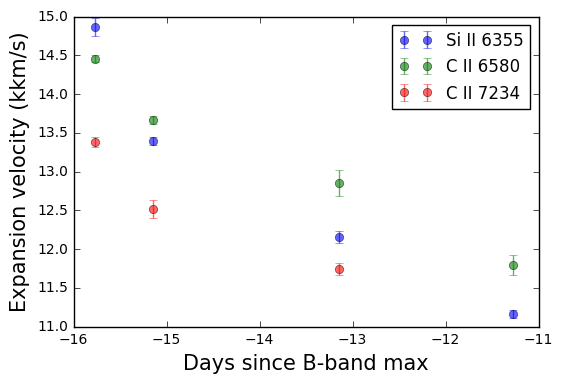

In [208]:
for i in range(3):
    # remove the last measurement in C II 7234
    if i == 2:
        idx = np.arange(0, 3)
    else:
        idx = np.arange(0, 4)
    plt.errorbar(phases[idx], vel[labels[i]][idx], 
                 yerr=vel_err[labels[i]][idx],
                 marker='o',
                 linestyle='none',
                 alpha=0.6,
                 label=labels[i])
plt.legend(loc="upper right")
plt.xlabel("Days since B-band max", fontsize=15)
plt.ylabel("Expansion velocity (kkm/s)", fontsize=15)

Si II 6355: phase=-10.1, center=6123.5 +/- 1.8, sigma=68.7 +/- 2.4, intensity=26.7 +/- 1.1
Si II 6355: phase= -8.1, center=6127.1 +/- 2.8, sigma=68.0 +/- 3.7, intensity=27.4 +/- 1.7
Si II 6355: phase= -7.5, center=6139.8 +/- 0.8, sigma=62.7 +/- 0.9, intensity=31.8 +/- 0.5


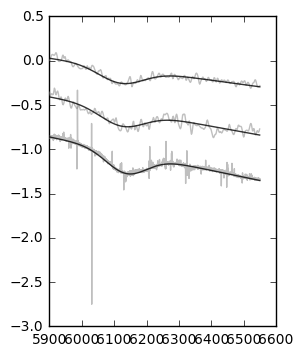

In [209]:
additional_phase = list()
additional_vel = list()
additional_vel_err = list()

fig = plt.figure()
fig.subplots_adjust(wspace=0.05)
ax = fig.add_subplot(1, 2, 1)
for i in [5, 7, 8]:
    spec = spectra[i]
    wv = spec.data["wavelength"]
    flx = spec.data["flux"]
    idx = np.logical_and(wv > 5900, wv < 6550)
    if np.sum(idx) < 20:
        continue
    ax.plot(wv[idx], flx[idx] / np.median(flx[idx]) + offset, color='gray', alpha=0.5, zorder=3)
    popt, pcov = FitSpec(spec, 
                         OneGaussianModel, 
                         [0, 0, 6150, 50, 0.2], 
                         lambda_range=[5900, 6550])
    model_flx = OneGaussianModel(wv[idx], *popt)
    ax.plot(wv[idx], model_flx / np.median(model_flx) + offset, color='k', alpha=0.8, zorder=5)
    
    # Si II 6355
    center = popt[2]
    center_err = pcov[2][2]**0.5
    width = popt[3]
    width_err = pcov[3][3]**0.5
    intensity = popt[4]
    intensity_err = pcov[4][4]**0.5
    center_measure = [(center, center_err)]
    pEW_measure = [(intensity, intensity_err)]
    print "Si II 6355: phase=%+5.1f, center=%.1f +/- %.1f, sigma=%.1f +/- %.1f, intensity=%.1f +/- %.1f" %\
        (spec.MJD - T_MAX, center, center_err, width, width_err, intensity, intensity_err)
    
    additional_phase.append(spec.MJD - T_MAX)
    additional_vel.append((1 - center / rest_wave[0]) * phys.c / 1e8)
    additional_vel_err.append(center_err / rest_wave[0] * phys.c / 1e8)
    offset -= 0.5

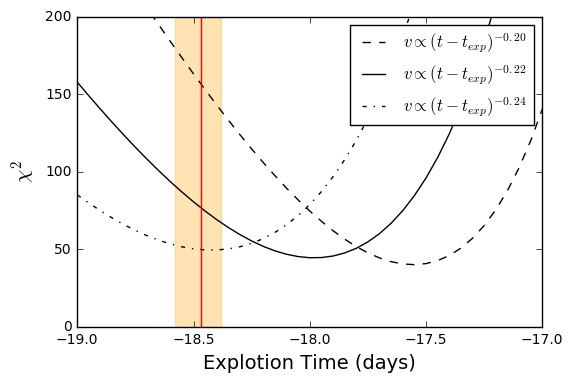

In [210]:
cat_phases = np.concatenate([phases, additional_phase])
cat_vel = np.concatenate([vel["Si II 6355"], additional_vel])
cat_vel_err = np.concatenate([vel_err["Si II 6355"], additional_vel_err])

t_range = np.linspace(-19, -17, 41)
chi2 = np.ndarray(t_range.shape)
for i in range(len(t_range)):
    t0 = t_range[i]
    x = (cat_phases - t0)**(-0.20)
    c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
    chi2[i] = np.sum(((c * x - cat_vel) / cat_vel_err)**2)
plt.plot(t_range, chi2, 'k--', label="$v\\propto (t-t_{exp})^{-0.20}$")

for i in range(len(t_range)):
    t0 = t_range[i]
    x = (cat_phases - t0)**(-0.22)
    c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
    chi2[i] = np.sum(((c * x - cat_vel) / cat_vel_err)**2)
plt.plot(t_range, chi2, 'k-', label="$v\\propto (t-t_{exp})^{-0.22}$")

for i in range(len(t_range)):
    t0 = t_range[i]
    x = (cat_phases - t0)**(-0.24)
    c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
    chi2[i] = np.sum(((c * x - cat_vel) / cat_vel_err)**2)
plt.plot(t_range, chi2, 'k-.', label="$v\\propto (t-t_{exp})^{-0.24}$")

plt.ylim(0, 200)
y_min, y_max = plt.ylim()
plt.plot([-18.47, -18.47], [y_min, y_max], 'r')
plt.fill_between([-18.58, -18.38], y1=y_min, y2=y_max, color='orange', alpha=0.3, zorder=1)

plt.xlabel("Explotion Time (days)", fontsize=14)
plt.ylabel("$\\chi^2$", fontsize=15)
plt.legend(loc='upper right')

plt.savefig("Chi2.pdf")

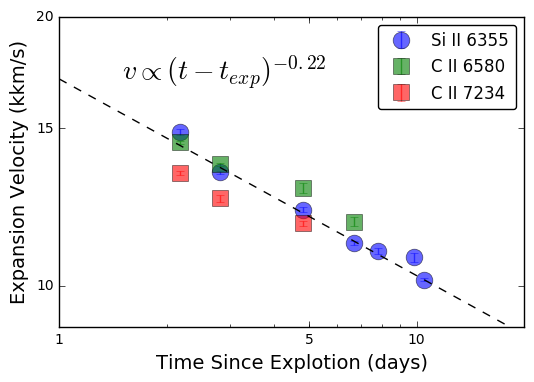

In [216]:
ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

t0 = -17.95
ax.errorbar(cat_phases - t0, cat_vel, 
            yerr=cat_vel_err, 
            marker='o',
            markerfacecolor='blue',
            markersize=12,
            linestyle='none', 
            label="Si II 6355",
            alpha=0.6)

for i in range(1, 3):
    # remove the last measurement in C II 7234
    if i == 2:
        idx = np.arange(0, 3)
    else:
        idx = np.arange(0, 4)
    plt.errorbar(phases[idx] - t0, vel[labels[i]][idx], 
                 yerr=vel_err[labels[i]][idx],
                 marker='s',
                 markersize=12,
                 linestyle='none',
                 alpha=0.6,
                 label=labels[i])
plt.legend(loc="upper right")

x = (cat_phases - t0)**(-0.22)
c = np.sum(x * cat_vel / cat_vel_err**2) / np.sum(x * x/ cat_vel_err**2)
t = np.linspace(1, 20, 100)
ax.plot(t, c * t**(-0.22), 'k--')
ax.set_xlim(1, 20)
ax.set_ylim(9, 20)
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(["1", "5", "10"])
ax.set_yticks([10, 15, 20])
ax.set_yticklabels(["10", "15", "20"])
ax.set_xlabel("Time Since Explotion (days)", fontsize=14)
ax.set_ylabel("Expansion Velocity (kkm/s)", fontsize=14)
ax.legend(loc="upper right", numpoints=1, fancybox=True)
ax.text(1.5, 17, "$v\\propto (t-t_{exp})^{-0.22}$", fontsize=20)

plt.savefig("VelocityPlot.pdf")